#Chest X-Ray (Pneumonia)

About Dataset


The dataset is organized into 2 folders (train, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,871 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.



In [28]:
# importing packages
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3

import os
import matplotlib.pyplot as plt
import cv2
import glob

In [5]:
# dowloading pretraind model Inception v3
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2024-06-01 17:07:39--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.207, 142.250.141.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   294MB/s    in 0.3s    

2024-06-01 17:07:39 (294 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [71]:
# Define our example directories and files
base_dir = '/content/drive/MyDrive/Machine Learning/Chest X-Ray (Pneumonia)/Chest X-Ray (Pneumonia)/chest_xray'

train_dir = os.path.join( base_dir, 'train')
val_dir = os.path.join( base_dir, 'val')

# Directory with training normal x-rays
train_normal_dir = os.path.join(train_dir, 'NORMAL')

# Directory with training pneumonia x-rays
train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')

# Directory with validation normal x-rays
val_normal_dir = os.path.join(val_dir, 'NORMAL')

# Directory with validation x-rays
val_pneumonia_dir = os.path.join(val_dir, 'PNEUMONIA')


# Adding to our data-augmentation parameters to ImageDataGenerator
Image_size = 180
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   zoom_range = 0.1,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1)


test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 32,
                                                    class_mode = 'binary',
                                                    target_size = (Image_size, Image_size))

# Flow validation images in batches of 32 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( val_dir,
                                                          batch_size  = 32,
                                                          class_mode  = 'binary',
                                                          target_size = (Image_size, Image_size))

print(f"There are {len(os.listdir(train_normal_dir))} images of normal x-ray for training.\n")
print(f"There are {len(os.listdir(train_pneumonia_dir))} images of pneumonia x-ray for training.\n")
print(f"There are {len(os.listdir(val_normal_dir))} images of normal x-ray for validation.\n")
print(f"There are {len(os.listdir(val_pneumonia_dir))} images of pneumonia x-ray for valiation.\n")

Found 5247 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
There are 1354 images of normal x-ray for training.

There are 3893 images of pneumonia x-ray for training.

There are 234 images of normal x-ray for validation.

There are 390 images of pneumonia x-ray for valiation.



Train Set - Normal


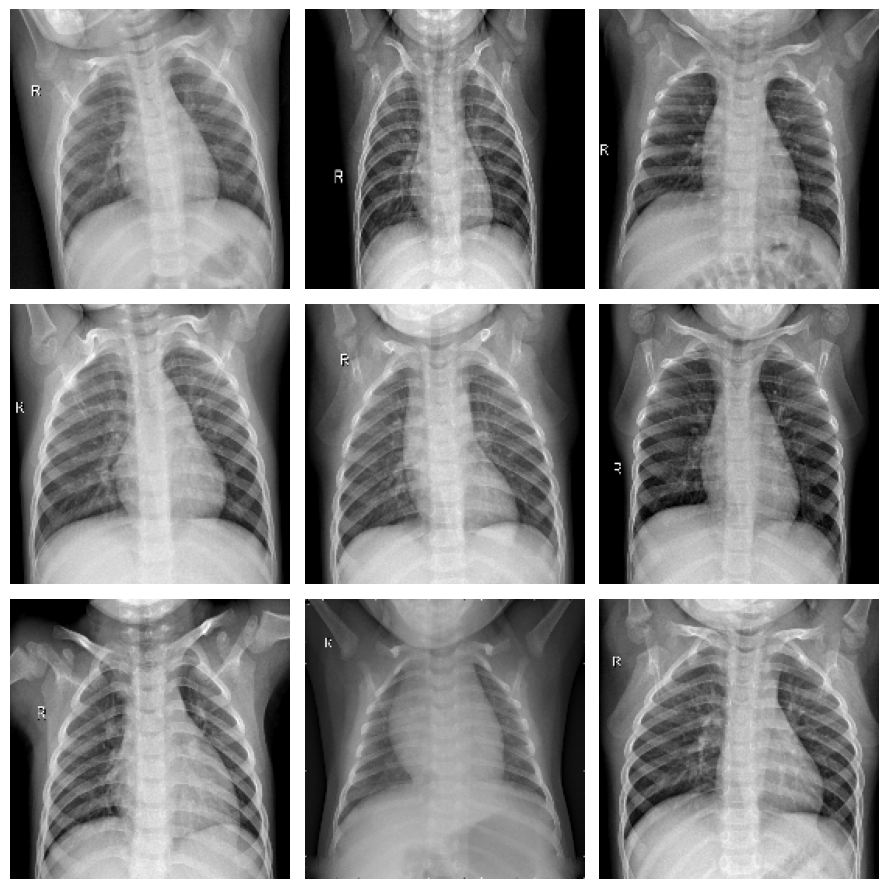

In [72]:
print('Train Set - Normal')
plt.figure(figsize=(9,9))
train_normal = glob.glob(train_normal_dir+"/*.jpeg")
for i in range(0, 9):
    plt.subplot(3,3,i + 1)
    img = cv2.imread(train_normal[i])
    img = cv2.resize(img, (Image_size,Image_size))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()


Train Set - Pneumonia


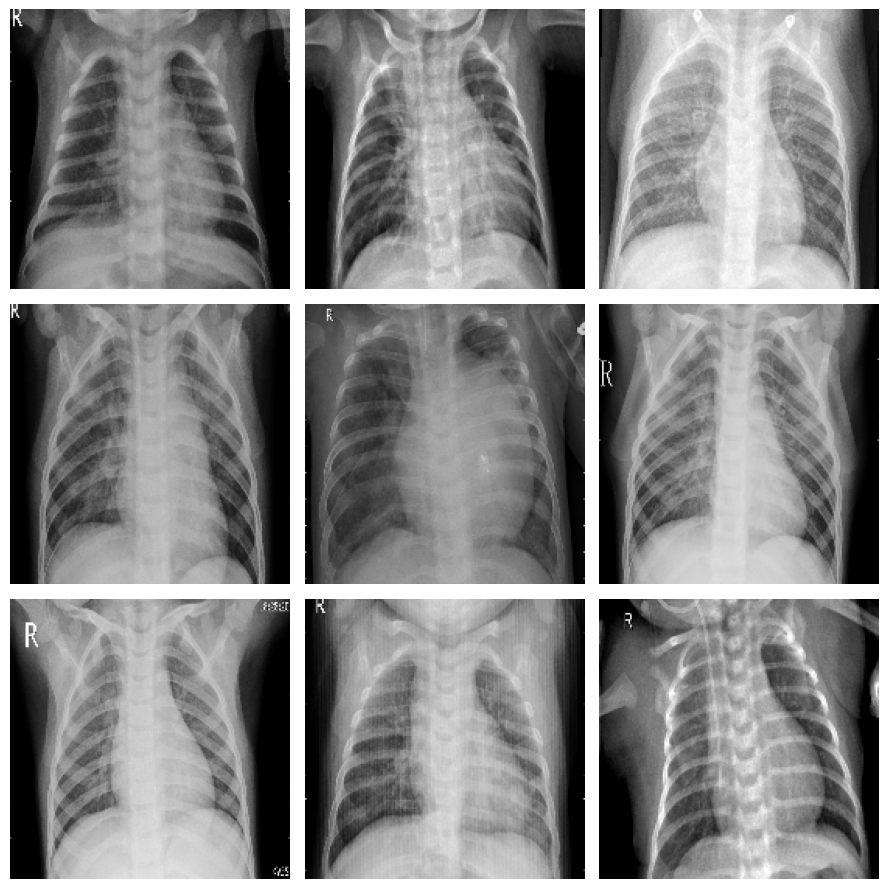

In [73]:
print('Train Set - Pneumonia')
plt.figure(figsize=(9,9))
train_normal = glob.glob(train_pneumonia_dir+"/*.jpeg")
for i in range(0, 9):
    plt.subplot(3,3,i + 1)
    img = cv2.imread(train_normal[i])
    img = cv2.resize(img, (Image_size,Image_size))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()


In [74]:
# Set the weights file you downloaded into a variable
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (Image_size, Image_size,3),
                                include_top = False,
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False


In [75]:
# Choosed `mixed7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 9, 9, 768)


In [76]:
# define the model
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

In [77]:
# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 40,892,065 total parameters in this model.
There are 31,916,801 trainable parameters in this model.


In [78]:
# Set the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [81]:
# train the model
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 5,
            verbose = 1)

Epoch 1/5
164/164 [==============================] - 120s 732ms/step - loss: 0.0873 - accuracy: 0.9687 - val_loss: 0.0834 - val_accuracy: 0.9712
Epoch 2/5
164/164 [==============================] - 117s 717ms/step - loss: 0.0727 - accuracy: 0.9716 - val_loss: 0.1010 - val_accuracy: 0.9615
Epoch 3/5
164/164 [==============================] - 114s 697ms/step - loss: 0.0750 - accuracy: 0.9741 - val_loss: 0.0997 - val_accuracy: 0.9567
Epoch 4/5
164/164 [==============================] - 114s 698ms/step - loss: 0.0687 - accuracy: 0.9739 - val_loss: 0.1108 - val_accuracy: 0.9599
Epoch 5/5
164/164 [==============================] - 117s 711ms/step - loss: 0.0635 - accuracy: 0.9748 - val_loss: 0.1844 - val_accuracy: 0.9375


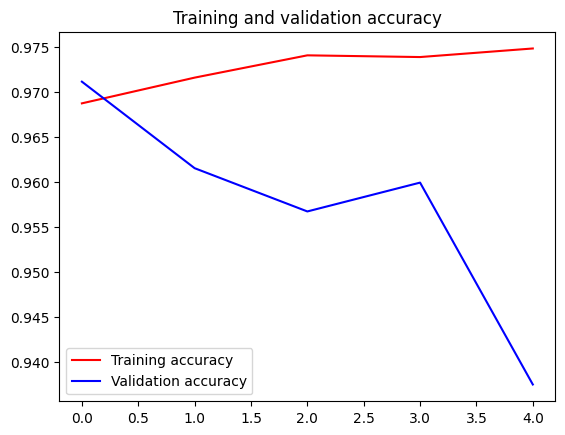

In [82]:
# plot metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)


plt.show()

In [83]:
#same the model
model.save("Chest_X-Ray_Pneumonia.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
